In [60]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from nn_utils import AE_3D_200
from utils import plot_activations


In [61]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle(BIN + 'processed_data/all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0])

# Normalize
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

db = basic_data.DataBunch(train_dl, valid_dl)

model = AE_3D_200()

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss()

bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [62]:
learn.load('AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x000001FF257873C8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x000001FF28C25208>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=WindowsPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_t

In [63]:
curr_save_folder = 'trainforever_plots/'

In [64]:
learn.validate()

[0.0070910202]

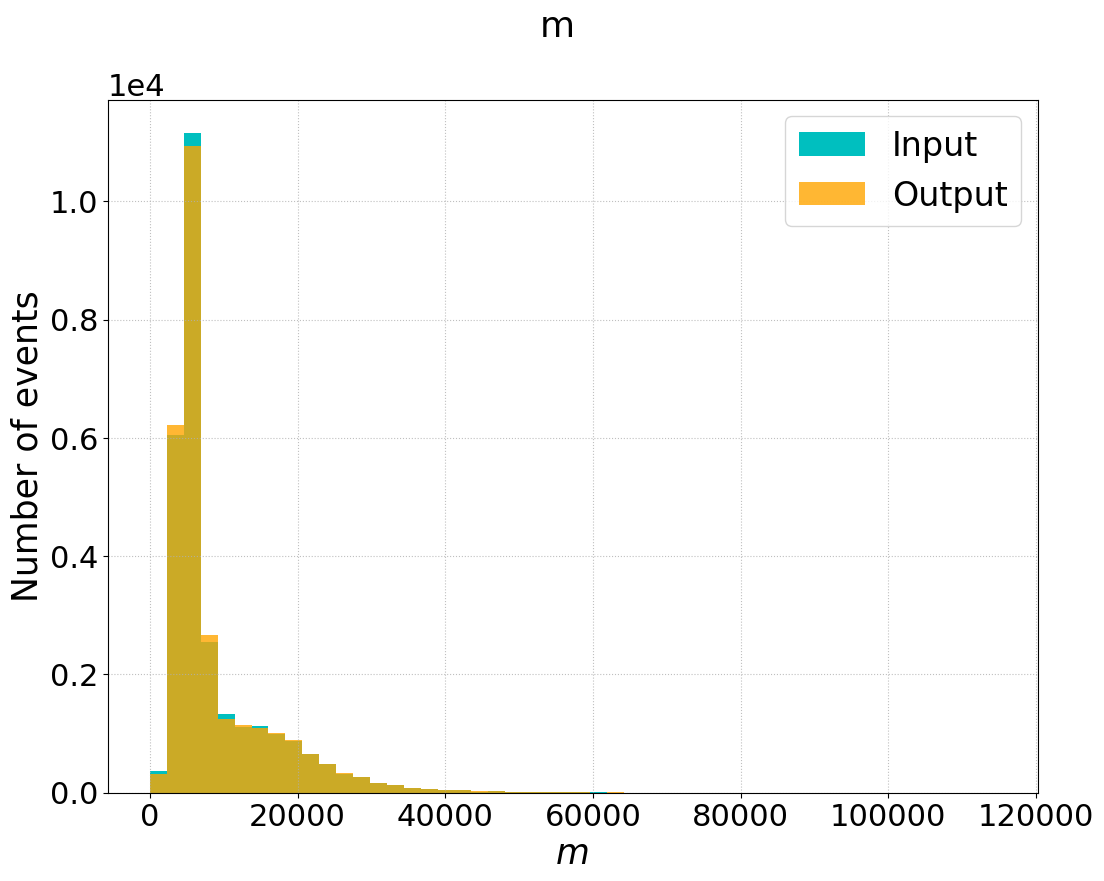

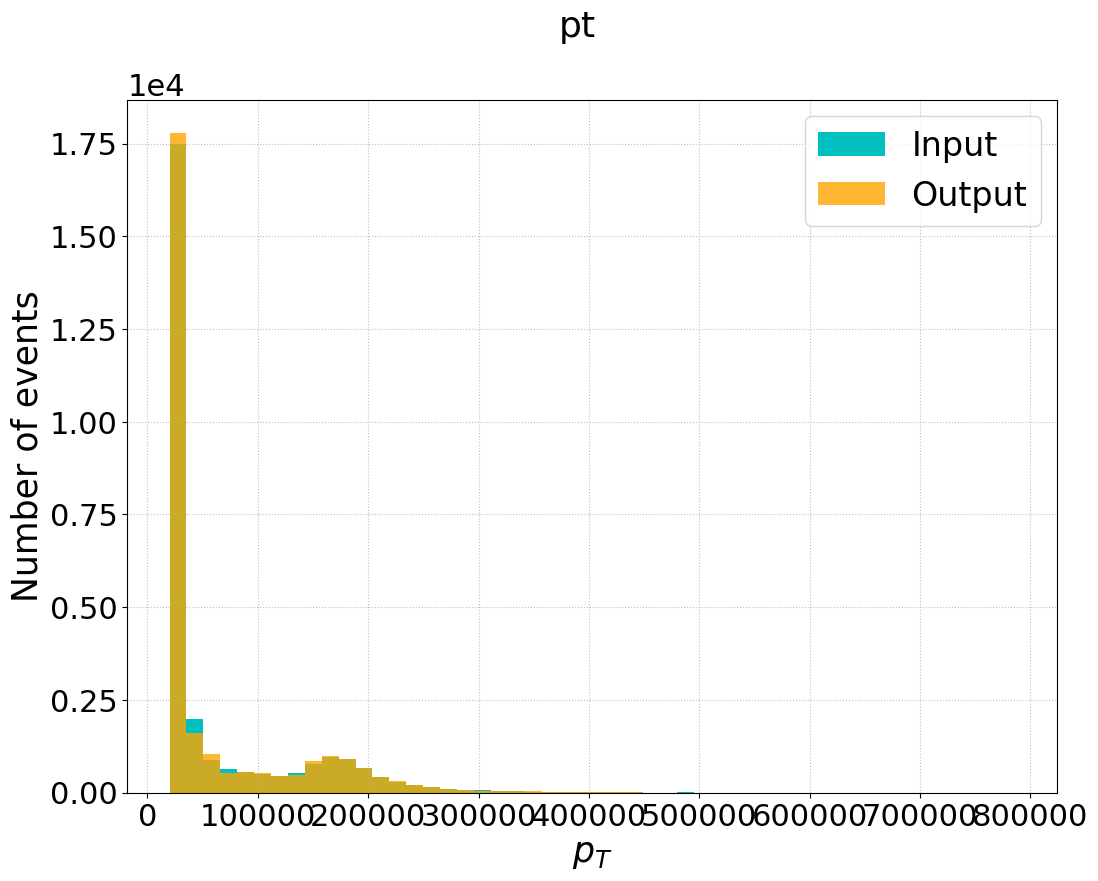

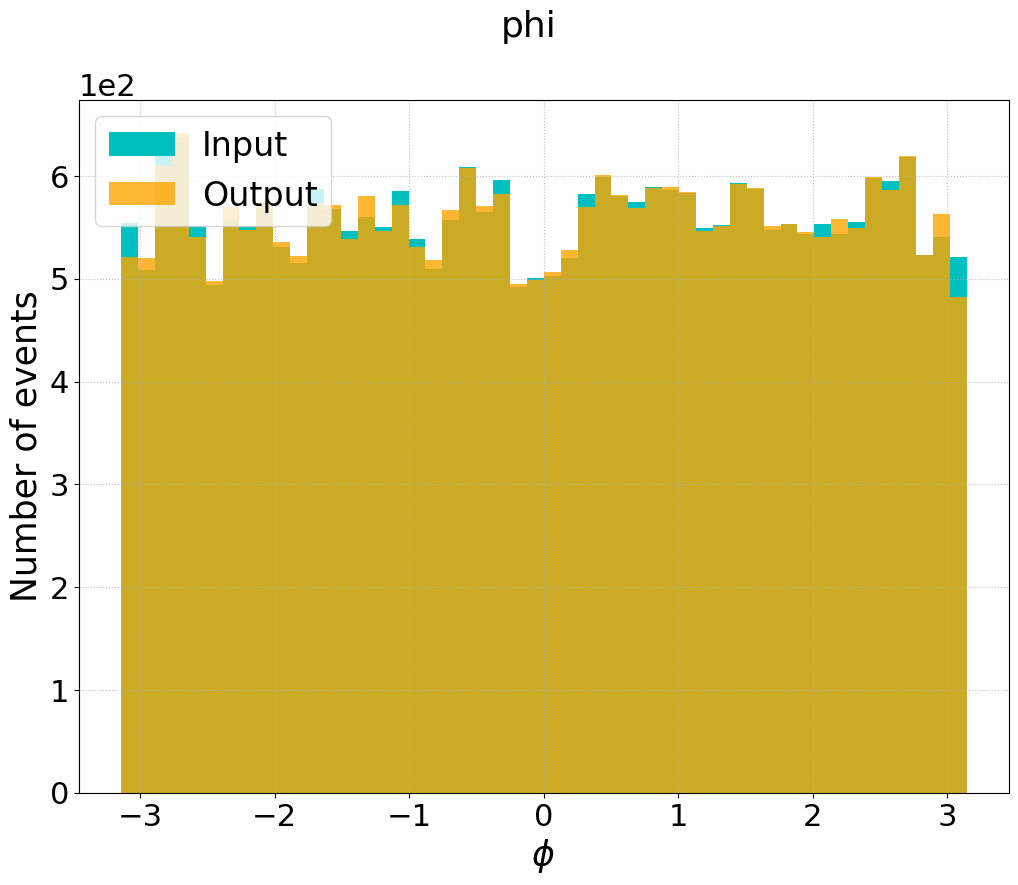

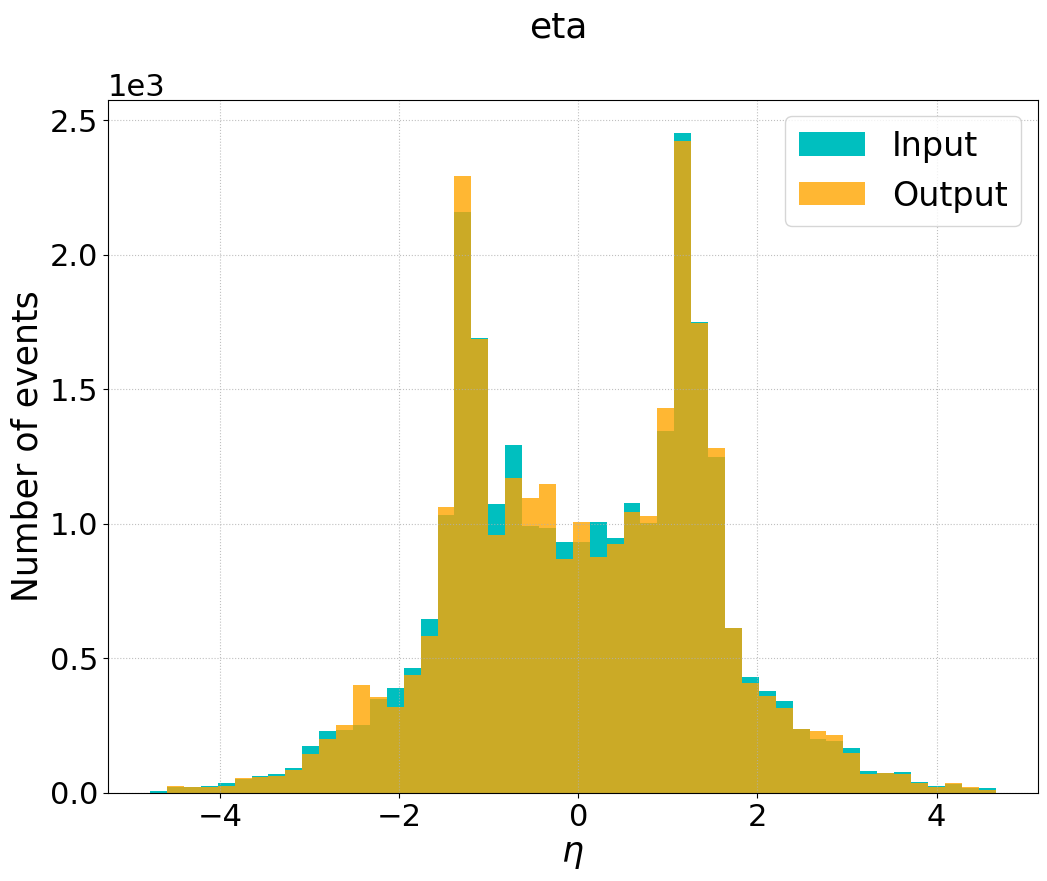

In [65]:
#plotting the input and output on top of each other, for each parameter, as histograms
#only one color(mixture of the two) will be visible when these overlap. We want maximum overlap
plt.close('all')
unit_list = ['', '', '', '']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.double()
model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


AttributeError: module 'utils' has no attribute 'std_error'

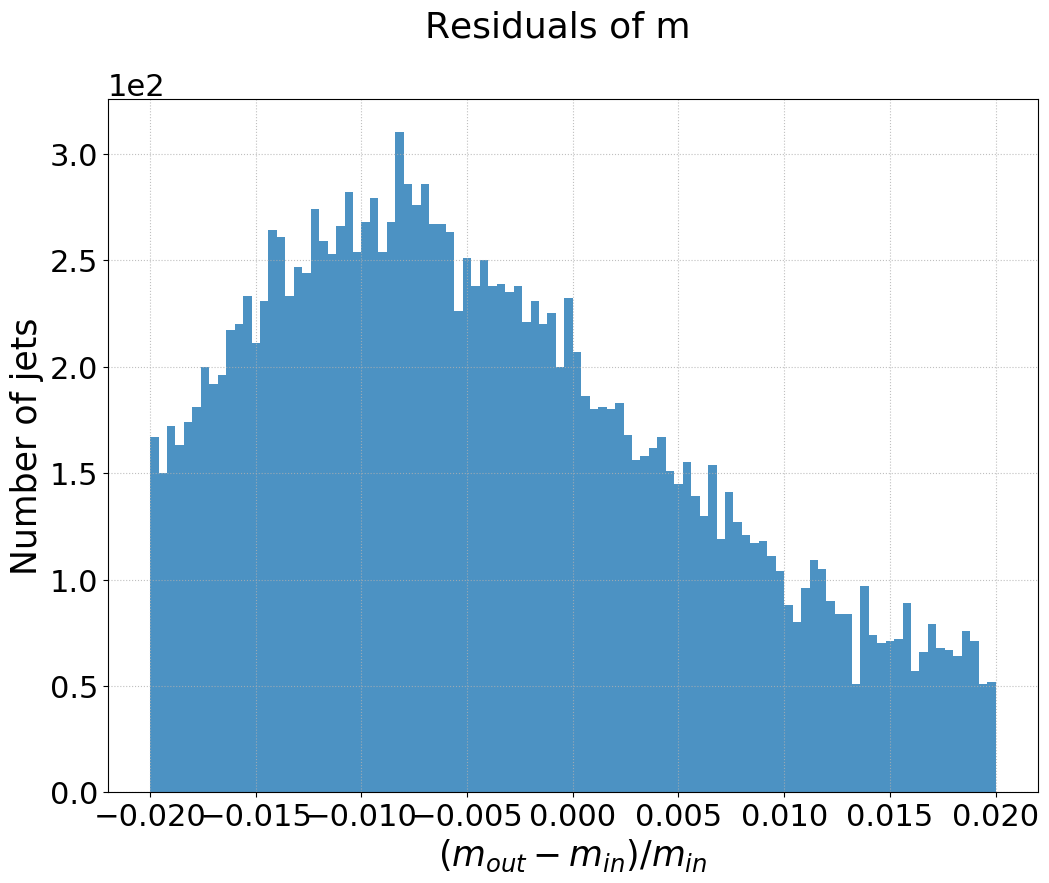

In [66]:
#residuals distributions' plotted, most of them should have mean very close to zero and low standard deviation is desirable 
import utils
from scipy import stats
residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
                        r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.02, .02)

#values corresponding to where m is zero (residual is infinity) are ignored for visualization purpose

for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.nanstd(residuals[:, kk][~np.isinf(residuals[:,kk])])
    std_err = utils.std_error(residuals[:, kk][~np.isinf(residuals[:,kk])])
    mean = np.nanmean(residuals[:, kk][~np.isinf(residuals[:,kk])])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    plt.savefig(curr_save_folder + fig_name)

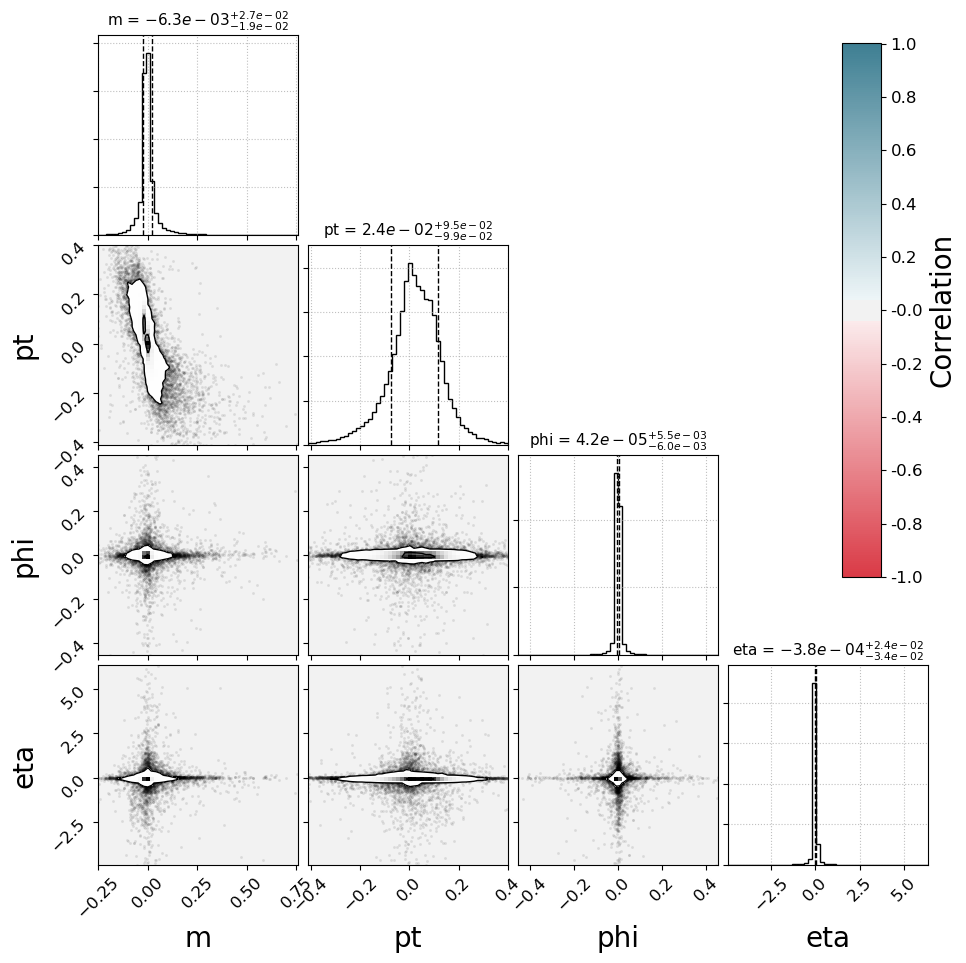

In [67]:
#all possible 2d contours plotted
import corner.corner as corner
import seaborn as sns

#values corresponding to where m is zero (residual is infinity) are ignored for visualization purpose 
res_df = pd.DataFrame({'m': residuals[:, 0][~np.isinf(residuals[:,0])], 'pt': residuals[:, 1][~np.isinf(residuals[:,0])], 'phi': residuals[:, 2][~np.isinf(residuals[:,0])], 'eta': residuals[:, 3][~np.isinf(residuals[:,0])]})
save = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['m', 'pt', 'phi', 'eta']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig(curr_save_folder + fig_name)